# Классификация текстов на реальных данных.

## Автоматический сбор информации из Интернет-ресурса по отзывам посетителей.

В качестве Интернет-ресурса возьму: Banki.ru

In [21]:
import warnings
import requests
import json
import nltk
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
from typing import List, Dict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud
warnings.filterwarnings("ignore")

In [47]:
nltk.download("stopwords") # для удаления стоп слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # для лемматизации
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kondr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kondr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kondr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kondr\AppData\Roaming\nltk_data...


True

In [54]:
def parse_url(url: str) -> List[Dict]:
    """Функция парсит страницу и возвращает Список из словарей с отзывами."""
    result = list() 
    page = requests.get(url)
    if page.status_code == 200:
        # парсинг html страницы: получение json из тега script с типом application/ld+json
        soup = bs(page.text, 'html.parser')
        reviews = soup.find_all('script', attrs={'type': 'application/ld+json'})
        reviews = json.loads(reviews[0].string, strict=False)
        reviews = reviews['review']
        # перебор всех элементов json, с сохранением в список result
        for elem in reviews:
            # созданием словаря, куда будем сохранять атрибуты json
            preresult = dict()
            # имя авторе - никнейм или None, в случае отсутсвия DELETED
            preresult['author'] = elem.setdefault('author', None)
            if preresult['author'] == 'DELETED':
                preresult['author'] = None
            # дата публикации отзыва
            preresult['datePublished'] = elem.setdefault('datePublished', None)
            # название банка, о котором написан отзыв
            preresult['bank'] = elem['itemReviewed'].setdefault('name', None)
            # телефон банка
            preresult['telephone'] = elem['itemReviewed'].setdefault('telephone', None)
            # адрес банка
            preresult['address'] = elem['itemReviewed']['address'].setdefault('streetAddress', None)
            # почтовый код банка
            preresult['postalCode'] = elem['itemReviewed']['address'].setdefault('postalCode', None)
            # назване отзыва
            preresult['name'] = elem.setdefault('name', None)
            # содержание отзыва
            preresult['review'] = elem.setdefault('reviewBody', None)
            # рейтинг клиента от 1 до 5 о банке
            preresult['rating'] = elem['reviewRating'].setdefault('ratingValue', None)
            # изменение типа данных рейтинга на целочисленное
            try:
                preresult['rating'] = int(preresult['rating'])
            except TypeError as e:
                preresult['rating'] = None
            # изменение типа почтового кода банка на целочисленное
            try:
                preresult['postalCode'] = int(preresult['postalCode'])
            except TypeError as e:
                preresult['postalCode'] = None
            # удаление лишних символов из содержания отзыва о банке
            try:
                preresult['review'] = preresult['review'].replace('&lt;p&gt;', '').replace('&lt;/p&gt;', '')
            except AttributeError as e:
                preresult['review'] = None
            result.append(preresult)
    return result

In [55]:
def parse_pages(url: str, pages: tuple) -> pd.DataFrame:
    "Функция парсин список страниц и возвращает структурированный датафрейм с отзывами."
    result = list()
    print("Обработка страниц:")
    for i in range(*pages):
        fulurl = f"{url}?page={i}"
        try:
            preresult = parse_url(fulurl)
            result.extend(preresult)
            print(f"{i} - OK. ", end='')
        except (requests.ConnectionError, TimeoutError, NameError, json.decoder.JSONDecodeError) as e:
            print(f"\n{i} - BAD. ", end='')
            continue
    result = pd.DataFrame.from_records(result)
    return result

In [56]:
%%time
data = parse_pages('https://www.banki.ru/services/responses/list/', (500, 1000))
data.to_csv('banki_1.csv', index=False)
data = pd.read_csv('banki_1.csv')
data.head()

Обработка страниц:
500 - OK. 501 - OK. 502 - OK. 503 - OK. 504 - OK. 505 - OK. 506 - OK. 507 - OK. 508 - OK. 509 - OK. 510 - OK. 511 - OK. 512 - OK. 513 - OK. 514 - OK. 515 - OK. 516 - OK. 517 - OK. 518 - OK. 519 - OK. 520 - OK. 521 - OK. 522 - OK. 523 - OK. 524 - OK. 525 - OK. 526 - OK. 527 - OK. 528 - OK. 529 - OK. 530 - OK. 531 - OK. 532 - OK. 533 - OK. 534 - OK. 535 - OK. 536 - OK. 537 - OK. 538 - OK. 539 - OK. 540 - OK. 541 - OK. 542 - OK. 543 - OK. 544 - OK. 545 - OK. 546 - OK. 547 - OK. 
548 - BAD. 549 - OK. 550 - OK. 551 - OK. 552 - OK. 553 - OK. 554 - OK. 555 - OK. 556 - OK. 557 - OK. 558 - OK. 559 - OK. 560 - OK. 561 - OK. 562 - OK. 563 - OK. 564 - OK. 565 - OK. 566 - OK. 567 - OK. 568 - OK. 569 - OK. 570 - OK. 571 - OK. 572 - OK. 573 - OK. 574 - OK. 575 - OK. 576 - OK. 577 - OK. 578 - OK. 579 - OK. 580 - OK. 581 - OK. 582 - OK. 583 - OK. 584 - OK. 585 - OK. 586 - OK. 587 - OK. 588 - OK. 589 - OK. 590 - OK. 591 - OK. 592 - OK. 593 - OK. 594 - OK. 595 - OK. 596 - OK. 597 - OK.

,author,datePublished,bank,telephone,address,postalCode,name,review,rating
0,user-26848700910,2023-07-28 06:32:17,Альфа-Банк,(495) 788-88-78,"г. Москва, ул. Каланчевская, д. 27",107078,Очень быстрое обслуживание,Добрый день! Хочу похвалить работников офиса в...,5
1,user-851914608778,2023-07-28 06:22:16,Сбербанк,900,"г. Москва, ул. Вавилова, д. 19",117997,Не увеличен лимит по кредитной карте,"20.07 пришло смс с номера 900 о том, что до 27...",1
2,user-618214608668,2023-07-28 05:59:40,Сбербанк,900,"г. Москва, ул. Вавилова, д. 19",117997,Кредитный лимит по карте так и не увеличили,20.07.2023 числа пришло смс с номера 900 от Сб...,3
3,user-931514608625,2023-07-28 05:32:31,Альфа-Банк,(495) 788-88-78,"г. Москва, ул. Каланчевская, д. 27",107078,Отличный банк,"Прекрасный банк, прекрасное обслуживание. Поль...",5
4,user-827814568551,2023-07-28 05:22:20,Сбербанк,900,"г. Москва, ул. Вавилова, д. 19",117997,Замена паспорта и вместе с ней потеря кредитно...,Приветствую. Столкнулся с пренеприятнейшей ист...,1


## Провидение предпроцессинга данных (очистку данных, удалите выбросов, пустые значения и т.д). Описательная статистика.

Преобразование даты в тип данных datetime64[ns] из строчного и получение информации о содержании датасета. Итого 12225 записи. Большая часть признаков - строчные данные, также имеются целочсиленный и один признак - дата. В одном из признаков присутствуют нулевые элементы.

In [22]:
data = pd.read_csv('banki_1.csv')
data['datePublished'] = data['datePublished'].astype('datetime64[ns]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12225 entries, 0 to 12224
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   author         12168 non-null  object        
 1   datePublished  12225 non-null  datetime64[ns]
 2   bank           12225 non-null  object        
 3   telephone      12225 non-null  object        
 4   address        12225 non-null  object        
 5   postalCode     12225 non-null  int64         
 6   name           12225 non-null  object        
 7   review         12225 non-null  object        
 8   rating         12225 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 859.7+ KB


Проверка на дубликаты. Всего 631 дубликат из 12225, их следует удалить.

In [23]:
print(len(data) - len(data.drop_duplicates()))
data = data.drop_duplicates()
data.shape[0]

631


11594

Проведём описательную статистику целевой переменной rating. Средний рейтинг равен 3.7.

In [4]:
data['rating'].describe()

count    11594.000000
mean         3.702691
std          1.778665
min          1.000000
25%          1.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

Проверим признаки на уникальность. Много уникальных значений в признаках review - основной признак для обучения модели, он понадобится в дальнейшем; name - название отзыва, также может пригодится для обучения; автор - никнейм человека, написавшего отзыв, не будет влиять на обучения модели, также в нём содержаться нулевые значения, его стоит удалить, так же как и дату, так как дата написания отзыва не соотносится с его содержимым.

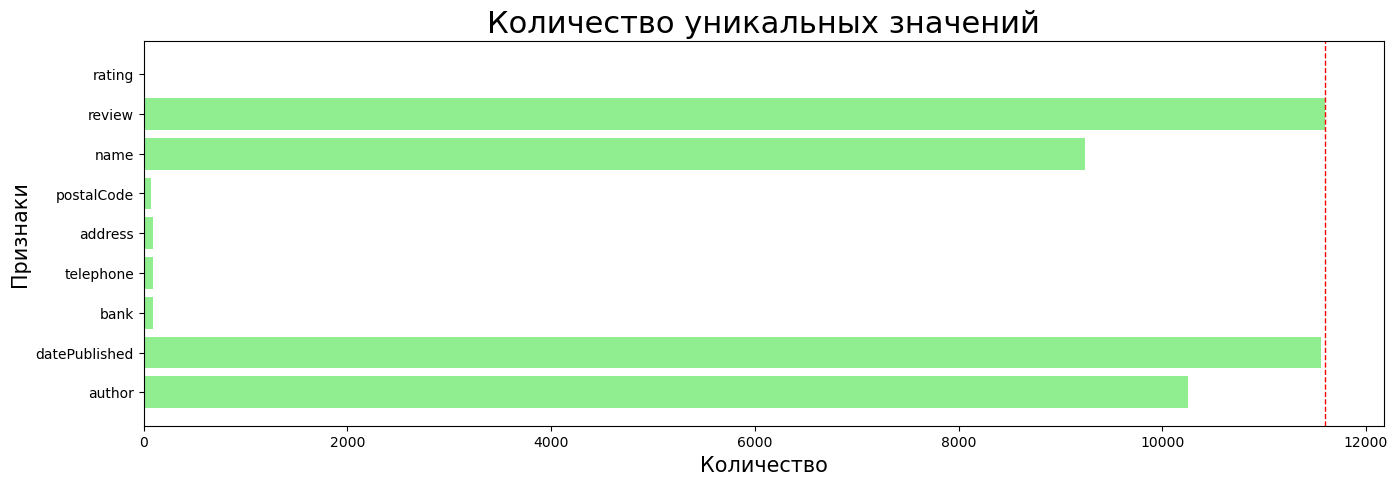

In [28]:
fig = plt.figure(figsize=(16,5))
ax=fig.subplots() 
ax.axvline(x=data.shape[0], color='r', label='Average', linestyle='--', linewidth=1)
plt.barh(data.columns, data.nunique(), align='center', color='lightgreen')
plt.title("Количество уникальных значений", fontsize=22)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Признаки', fontsize=15)
plt.show()

In [24]:
data.drop(columns=['author', 'datePublished'], axis=1, inplace=True)

## Анализ предметной области.

Посмотрим на распределение целевой переменной. Рейтинг со значением 5 и 1 наиболее часто встречается, 2, 3, 4 - реже. Наблюдается дисбаланс. Как вариант далее в предобработке можно понизить мажоритарный класс до определённого значения и/или объединить несколько признаков в один, чтобы в итоге оставалось всего да.

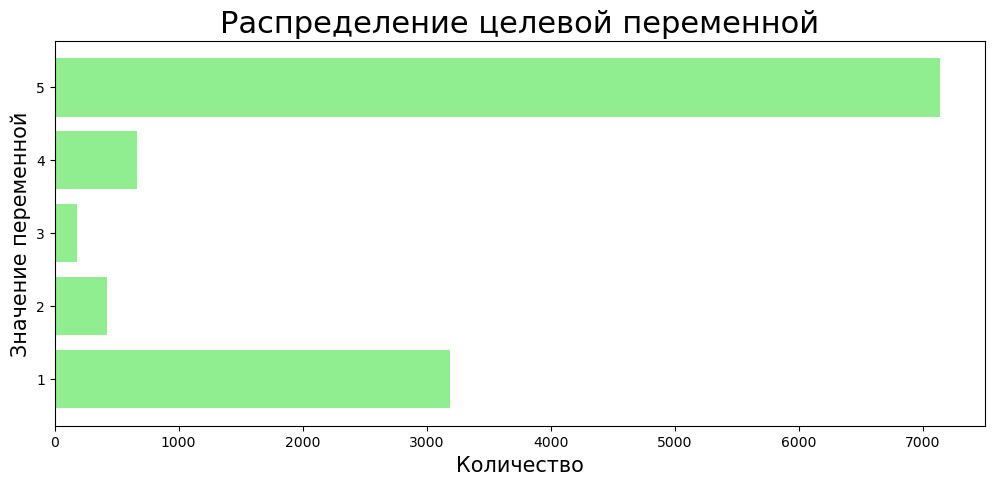

In [82]:
rating = data['rating'].value_counts()
fig = plt.figure(figsize=(12,5))
ax=fig.subplots()
plt.barh(rating.index, rating.values, align='center', color='lightgreen')
plt.title("Распределение целевой переменной", fontsize=22)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Значение переменной', fontsize=15)
plt.show()

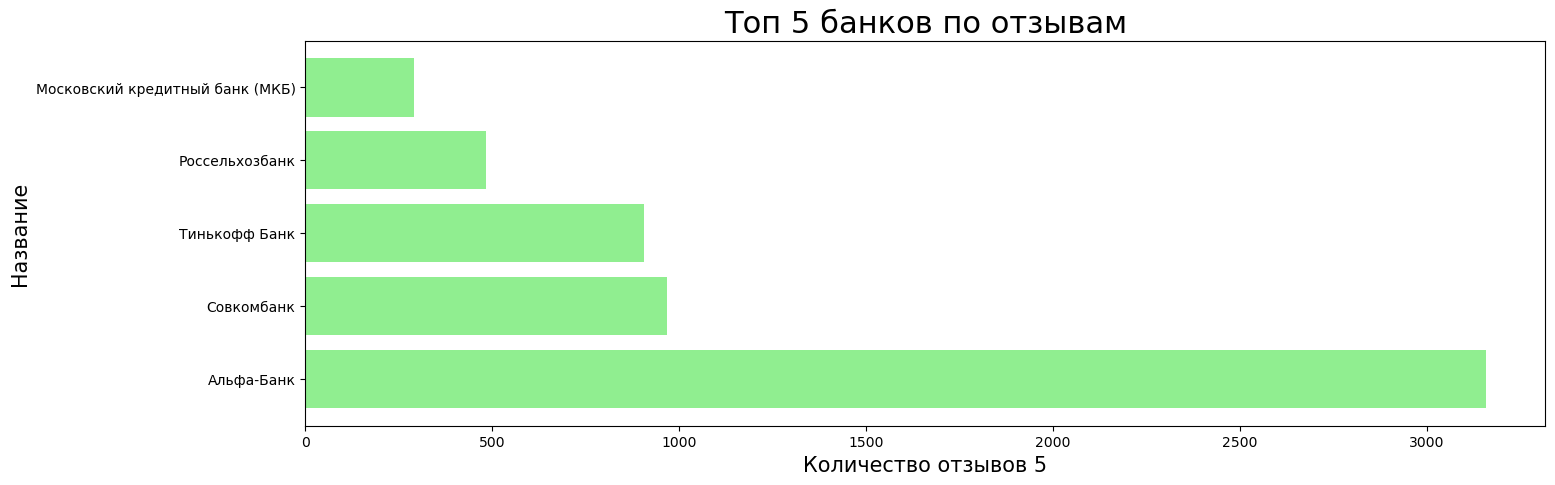

In [125]:
rating_5 = data[data['rating'] == 5].bank.value_counts()[:5]
fig = plt.figure(figsize=(16,5))
plt.barh(rating_5.index, rating_5.values, align='center', color='lightgreen')
plt.title("Топ 5 банков по отзывам", fontsize=22)
plt.xlabel('Количество отзывов 5', fontsize=15)
plt.ylabel('Название', fontsize=15)
plt.show()

Проверим, как коррелируют признаки postalCode, address, telephone и bank. Перед этим заменим качественные признаки числами. Как видно по графику, postalCode, address, telephone и bank сильно коррелируют, следовательно, три из этих признака стоит удалить из датасета. Удалю address, postalCode и telephone.

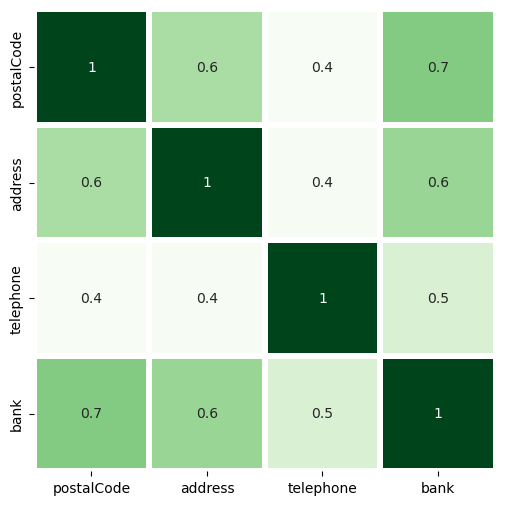

In [25]:
labeler = LabelEncoder()
data.loc[:, ['postalCode', 'address', 'telephone', 'bank']] = data.loc[:, ['postalCode', 'address', 'telephone', 'bank']].apply(labeler.fit_transform)
df_corr = data[['postalCode', 'address', 'telephone', 'bank']].corr().abs()
f=plt.figure(figsize=(6,6))
corr_matrix = sns.heatmap(df_corr,
                          annot = True, 
                          fmt = '.1g',
                          linewidths = 4,
                          cbar = False, 
                          square = True,
                          cmap='Greens',
                          xticklabels = df_corr.columns,
                          yticklabels = df_corr.columns)

In [26]:
data.drop(columns=['postalCode', 'address', 'telephone'], axis=1, inplace=True)
data.head()

,bank,name,review,rating
0,7,Очень быстрое обслуживание,Добрый день! Хочу похвалить работников офиса в...,5
1,68,Не увеличен лимит по кредитной карте,"20.07 пришло смс с номера 900 о том, что до 27...",1
2,68,Кредитный лимит по карте так и не увеличили,20.07.2023 числа пришло смс с номера 900 от Сб...,3
3,7,Отличный банк,"Прекрасный банк, прекрасное обслуживание. Поль...",5
4,68,Замена паспорта и вместе с ней потеря кредитно...,Приветствую. Столкнулся с пренеприятнейшей ист...,1


## Обработка текста. Сравните классов.

Обработка строчных данных:

In [27]:
# определение строк
str_1 = '. '
regex_1 = r'(?<=\().+?(?=\))'
regex_2 = r'[\d\(\)a-zA-Z]'
# Объединение названий отзывов и их содержимых
data['bank'] = labeler.inverse_transform(data['bank'])
data['review'] = data['bank'] + str_1 + data['name'] + str_1 + data['review']
data.drop(columns=['name', 'bank'], inplace=True)
# Удаление содержимого в скобках и приведение к нижнему регист
data['review'] = data['review'].str.lower().replace(regex_1, '', regex=True)
# Удаление чисел, скобок и латинский алфавит
data['review'] = data['review'].str.replace(regex_2, '', regex=True)
data.head()

,review,rating
0,альфа-банк. очень быстрое обслуживание. добрый...,5
1,сбербанк. не увеличен лимит по кредитной карте...,1
2,сбербанк. кредитный лимит по карте так и не ув...,3
3,"альфа-банк. отличный банк. прекрасный банк, пр...",5
4,сбербанк. замена паспорта и вместе с ней потер...,1


Баланс классов:

In [24]:
data['rating'].value_counts()

5    7142
1    3188
4     660
2     421
3     183
Name: rating, dtype: int64

In [28]:
one = data[data['rating'] == 1]
two = data[data['rating'] == 2]
three = data[data['rating'] == 3]
four = data[data['rating'] == 4]
five = data[data['rating'] == 5]

0) Без балансировки класса

1) Понижение мажоритарного признака до уровня миноритарного (значение 1, 2, 4, 5 до уровня 3):

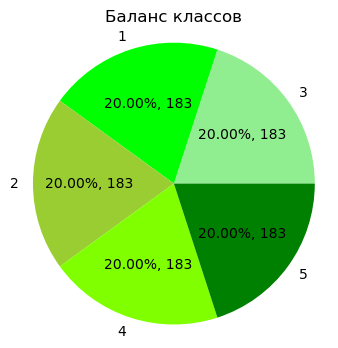

In [29]:
balanced_1 = pd.concat([three,
                        one.sample(n=three.shape[0], random_state=25),
                        two.sample(n=three.shape[0], random_state=25),
                        four.sample(n=three.shape[0], random_state=25),
                        five.sample(n=three.shape[0], random_state=25)])
plt.figure(figsize=(4, 4))
value_counts = balanced_1['rating'].value_counts()
plt.pie(value_counts, labels=value_counts.index,
        autopct=lambda p:f'{p:.2f}%, {p * sum(value_counts) / 100 :.0f}',
        colors=['lightgreen', 'lime', 'yellowgreen', 'chartreuse', 'green'])
plt.title('Баланс классов')
plt.axis('equal')
plt.show()

2)Объединение нескольких классов в один и приведение до одинакового значения (объединение 1, 2, 3, 4 в один класс и 5 в отдельный). Так отзывы будут разделены на "удовлетворительно" и "неудовлетворительно" :

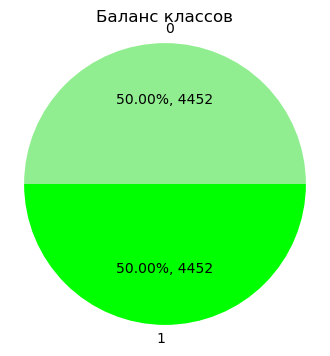

In [30]:
balanced_2 = pd.concat([five.replace(5, 1),
                        one.replace(1, 0),
                        two.replace(2, 0),
                        three.replace(3, 0),
                        four.replace(4, 0)])
one = balanced_2[balanced_2['rating'] == 1]
zero = balanced_2[balanced_2['rating'] == 0]
balanced_2 = pd.concat([zero,
                        one.sample(n=zero.shape[0], random_state=25)])
plt.figure(figsize=(4, 4))
value_counts = balanced_2['rating'].value_counts()
plt.pie(value_counts, labels=value_counts.index,
        autopct=lambda p:f'{p:.2f}%, {p * sum(value_counts) / 100 :.0f}',
        colors=['lightgreen', 'lime'])
plt.title('Баланс классов')
plt.axis('equal')
plt.show()

3)Повышение миноритарных признаков до уровня среднего значения (4) с понижением мажоритарных путём дублирования записей миноров (2, 3) и случайной выборки из мажоров (1, 5)

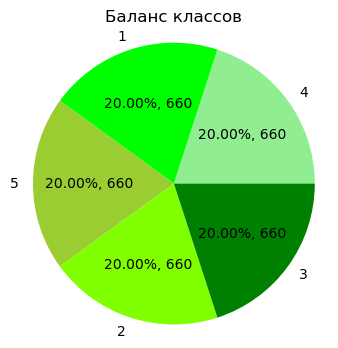

In [31]:
balanced_3 = pd.concat([four,
                        one.sample(n=four.shape[0], random_state=25),
                        five.sample(n=four.shape[0], random_state=25),
                        two.sample(n=four.shape[0], random_state=25, replace=True),
                        three.sample(n=four.shape[0], random_state=25, replace=True)])
plt.figure(figsize=(4, 4))
value_counts = balanced_3['rating'].value_counts()
plt.pie(value_counts, labels=value_counts.index,
        autopct=lambda p:f'{p:.2f}%, {p * sum(value_counts) / 100 :.0f}',
        colors=['lightgreen', 'lime', 'yellowgreen', 'chartreuse', 'green'])
plt.title('Баланс классов')
plt.axis('equal')
plt.show()

Векторизация текстовых данных двумя способами:

1)Векторизация через CountVectorizer:

In [32]:
def countv(dataset: pd.DataFrame, text=None):
    # объект для векторизирования и список стоп слов на русском
    data_copy = dataset.copy()
    stop_words = stopwords.words('russian')
    count = CountVectorizer(stop_words=stop_words)
    # Разбиение на тестовую и тренировочную выборки
    X, y = data_copy.drop(columns=['rating']), data_copy['rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=100)
    # Векторизация
    X_train = count.fit_transform(X_train['review'])
    if text is not None:
        text_countv = count.transform(text)
        return text_countv
    X_test = count.transform(X_test['review'])
    return X_train, X_test, y_train, y_test

2)Векторизация через TFIDF:

In [33]:
def tfidf(dataset: pd.DataFrame, text=None):
    # объект для векторизирования и список стоп слов на русском
    data_copy = dataset.copy()
    stop_words = stopwords.words('russian')
    tfidfv = TfidfVectorizer(stop_words=stop_words)
    # Разбиение на тестовую и тренировочную выборки
    X, y = data_copy.drop(columns=['rating']), data_copy['rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=100)
    # Векторизация
    X_train = tfidfv.fit_transform(X_train['review'])
    if text is not None:
        text_tfidfv = tfidfv.transform(text)
        return text_tfidfv
    X_test = tfidfv.transform(X_test['review'])
    return X_train, X_test, y_train, y_test

Разбиение по-разному сбалансированного датасета на тестовые и тренировочные выборки через разные способы преобразования текста:

In [34]:
x_y_train_test = {'countv(unbalanced)': countv(data), 'tfidf(unbalanced)': tfidf(data),
                  'countv(balanced_1)': countv(balanced_1), 'tfidf(balanced_1)': tfidf(balanced_1),
                  'countv(balanced_2)': countv(balanced_2),'tfidf(balanced_2)': tfidf(balanced_2),
                  'countv(balanced_3)': countv(balanced_3),'tfidf(balanced_3)': tfidf(balanced_3)}

### Применение нескольких видов машинного обучения и сравнение метрик эффективности.

Обучение моделей с различными тренировочными и тестовыми данными:

In [15]:
result = {'model': [], 'train_time': [], 'test_time': [], 'accuracy': [], 'type': []}

In [1]:
def train(model, X_train, X_test, y_train, y_test, **kwargs) -> tuple:
    """Тренировка модели"""
    start = time.time()
    model = model(**kwargs).fit(X_train, y_train)
    train_time = time.strftime("%H:%M:%S", time.gmtime(round(time.time() - start, 2)))
    y_train_pred = model.predict(X_train)
    start = time.time()
    y_test_pred = model.predict(X_test)
    test_time = time.strftime("%H:%M:%S", time.gmtime(round(time.time() - start, 2)))
    score_train = round(accuracy_score(y_train, y_train_pred), 4)
    score_test = round(accuracy_score(y_test, y_test_pred), 4)
    return train_time, score_train, score_test, test_time

In [2]:
def training_graph(v_bs: list, train_ts: list, train_scrs: list, test_ts: list, test_scrs: list) -> None:
    """График сравнения скорости обучения и тестирования и разных метрик на разных датасетах"""
    plt.figure(figsize=(8, 6))
    plt.bar(v_bs, train_scrs, width=.5, label='На тренировочных данных', alpha=.5, color='#ADFF2F')
    plt.bar(v_bs, test_scrs, width=.5, label='На тестовых данных', alpha=.5, color='#32CD32')
    for i in range(len(v_bs)):
        plt.text(i, 1, train_ts[i], ha = 'center')
        time_n_acc = f'{test_ts[i]}\n{test_scrs[i]}'
        plt.text(i, test_scrs[i], time_n_acc, ha = 'center', bbox = dict(facecolor = '#32CD32', alpha =.8))
    plt.title('Результат модели при разной балансировки и разной векторизации', fontweight ='bold')
    plt.xlabel('Датасеты', fontweight ='bold')
    plt.xticks(rotation=15)
    plt.ylabel('Метрика точности', fontweight ='bold')
    plt.legend(loc='lower center')
    plt.show()

In [17]:
def train_model(model, x_y_train_test, **kwargs) -> None:
    """Запуск функции обучения модели и сохранение результатов, возравщаемых функцией"""
    global result
    vector_balances, train_times, train_scores, test_times, test_scores = [], [], [], [], []
    for train_test in list(x_y_train_test.items()):
        result_training = train(model, train_test[1][0], train_test[1][1], train_test[1][2], train_test[1][3],
                       **kwargs)
        vector_balances.append(train_test[0])
        train_times.append(result_training[0])
        train_scores.append(result_training[1])
        test_scores.append(result_training[2])
        test_times.append(result_training[3])
        result['model'].append(type(model()).__name__)
        result['train_time'].append(result_training[0])
        result['accuracy'].append(result_training[2])
        result['test_time'].append(result_training[3])
        result['type'].append(train_test[0])
    training_graph(vector_balances, train_times, train_scores, test_times, test_scores)

In [18]:
def gridsearch_best(model, dataset_name, params) -> dict:
    """Функция поиска и выбора наиболее оптимальных гиперпараметров для модели"""
    x, y = x_y_train_test[dataset_name][0], x_y_train_test[dataset_name][2]
    x_test, y_test = x_y_train_test[dataset_name][1], x_y_train_test[dataset_name][3]
    estimator = model().fit(x, y)
    gscv = GridSearchCV(estimator=estimator, param_grid=params, cv=5, scoring='accuracy').fit(x, y)
    model = model(**gscv.best_params_).fit(x, y)
    y_train_pred = model.predict(x)
    y_pred = model.predict(x_test)
    print('accuracy_score train:', round(accuracy_score(y, y_train_pred), 4))
    print('accuracy_score test:', round(accuracy_score(y_test, y_pred), 4))
    return gscv.best_params_

### Модель Логистической регрессии:

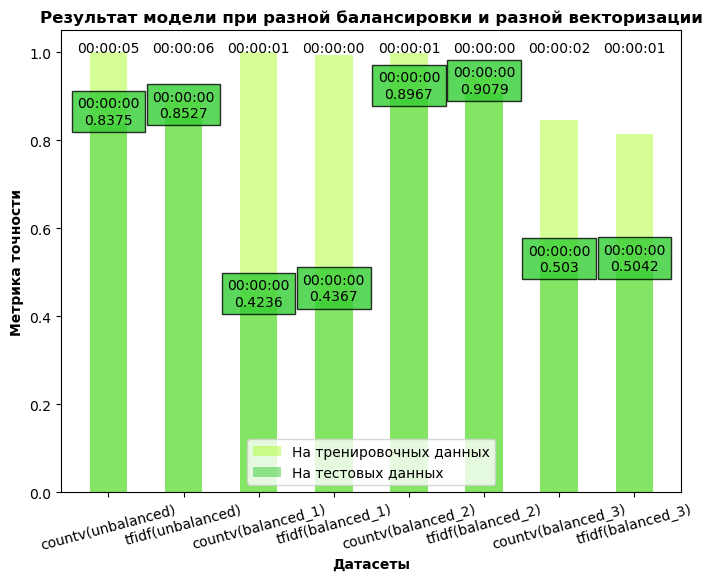

Wall time: 19.6 s


In [20]:
%%time
train_model(LogisticRegression, x_y_train_test)

In [19]:
params, model = {'penalty': ['l1', 'l2', 'elasticnet', None],
          'tol': [0.0001, 0.001, 0.01, 0.1, 1],
          'C': [0.10, 1, 10]}, LogisticRegression

In [61]:
%%time
gridsearch_best(model, 'tfidf(balanced_3)', params)

accuracy_score train: 0.8465
accuracy_score test: 0.52
Wall time: 1min 31s


In [62]:
%%time
gridsearch_best(model, 'countv(balanced_2)', params)

accuracy_score train: 0.9709
accuracy_score test: 0.9048
Wall time: 1min 4s


In [64]:
%%time
gridsearch_best(model, 'tfidf(unbalanced)', params)

accuracy_score train: 0.9991
accuracy_score test: 0.8537
Wall time: 5min 29s


Вывод: логистическая регрессия обучается быстро. Наблюдается переобучение на всех датасетов, кроме несбалансированного tfidf. Наилучший результат даёт обучение на двух признаках без переобучения. Для пяти признаков несбалансированные датасет среди других даёт наивысший результат. Подбор гиперпараметров не даёт серьёзных изменений.

### Модель опорных векторов

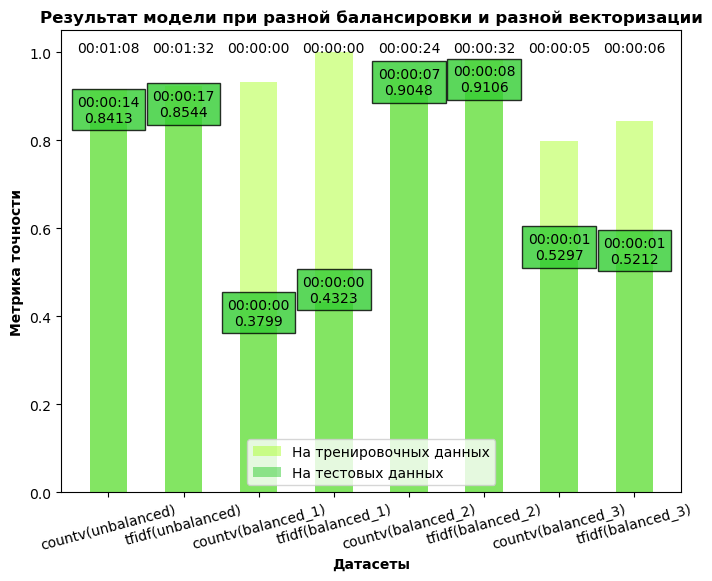

Wall time: 7min 28s


In [21]:
%%time
train_model(SVC, x_y_train_test)

In [58]:
params, model = {'max_iter': [-1, 10, 100, 200],
          'tol': [0.001, 0.01, 0.1, 1],
          'C': [0.01, 0.1, 1, 10]}, SVC

In [59]:
%%time
gridsearch_best(model, 'countv(balanced_3)', params)

accuracy_score train: 0.7766
accuracy_score test: 0.5758
Wall time: 12min 5s


{'C': 10, 'max_iter': 200, 'tol': 0.001}

Вывод: метод опорых векторов значительно уступает по скорости обучения логистической регрессии, но даёт эффективность с небольшой разницей в пару процентов. Подбор гиперпараметров дал небольшой улучшение на третьей балансировке, но тот же подбор может уйти в бесконечный цикл, либо обучаться слишком долго на больших датасетов. Можно испоьзовать как финальную модель.

### Модель k-ближайших соседей:

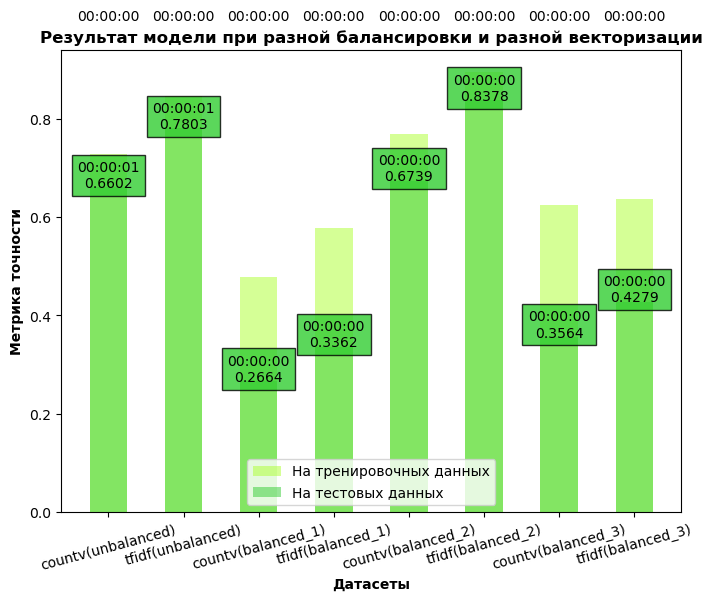

Wall time: 20 s


In [22]:
%%time
train_model(KNeighborsClassifier, x_y_train_test)

In [34]:
params, model = {'n_neighbors': [3, 4, 5, 6, 7],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'weights': ['uniform', 'distance']}, KNeighborsClassifier

In [35]:
%%time
gridsearch_best(model, 'tfidf(balanced_3)', params)

accuracy_score train: 0.8465
accuracy_score test: 0.4739
Wall time: 16.8 s


In [36]:
%%time
gridsearch_best(model, 'tfidf(balanced_2)', params)

accuracy_score train: 0.8905
accuracy_score test: 0.8491
Wall time: 1min 50s


In [37]:
%%time
gridsearch_best(model, 'tfidf(unbalanced)', params)

accuracy_score train: 0.8394
accuracy_score test: 0.7979
Wall time: 3min


Вывод: модель k-ближайших соседей слабо переобучается, на некоторых датасетах недообучается. Учится быстро и даёт высокий результат на несбалансированных классах и сбалансированных до 2. При подборе гиперпараметров результат был улучшен ещё сильнее, но всё равно уступает предыдущим моделям. Как приорететная в использовании остаётся метод опорных векторов и для бинарной и для многоклассовой классификации.

### Модель дерева решений:

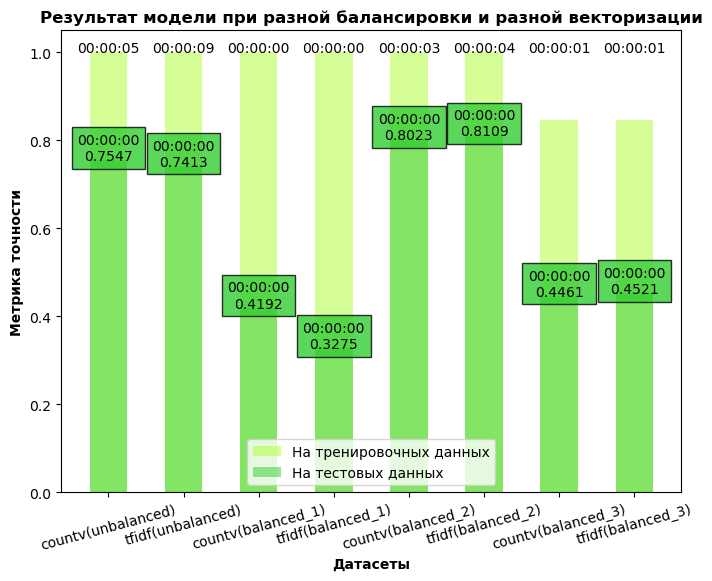

Wall time: 25.9 s


In [23]:
%%time
train_model(DecisionTreeClassifier, x_y_train_test)

In [40]:
params, model = {'min_samples_leaf': [None, 1, 3, 5],
          'criterion': ['gini', 'entropy', 'log_loss'],
          'max_depth': ['None', 2, 4]}, DecisionTreeClassifier

In [41]:
%%time
gridsearch_best(model, 'tfidf(balanced_3)', params)

accuracy_score train: 0.4
accuracy_score test: 0.3503
Wall time: 8.93 s


In [43]:
%%time
gridsearch_best(model, 'countv(balanced_2)', params)

accuracy_score train: 0.7821
accuracy_score test: 0.7826
Wall time: 31.5 s


In [45]:
%%time
gridsearch_best(model, 'countv(unbalanced)', params)

accuracy_score train: 0.7382
accuracy_score test: 0.7289
Wall time: 38.6 s


Вывод: модель дерева решений обучается очень быстро, но сильно переобучается. Подбор гиперпараметров устранил переобучение, но снизил эффективность модели. Метод опорных векторов всё ещё эффективнее.

### Модель перцептрона:

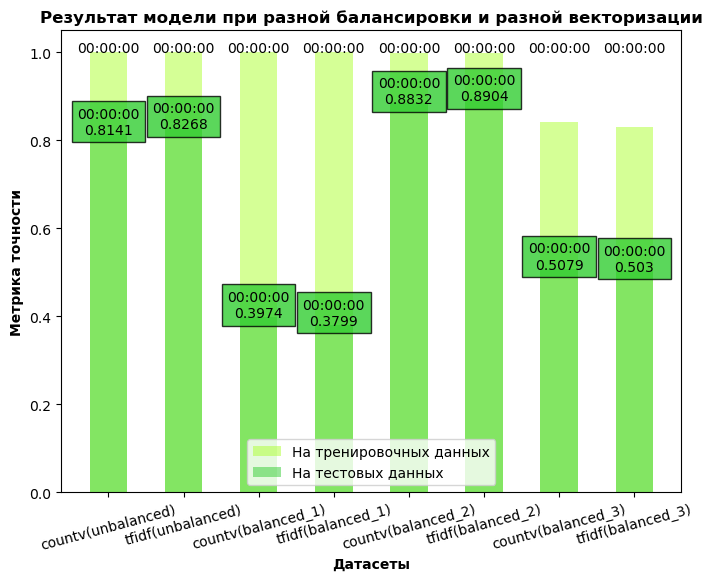

Wall time: 784 ms


In [24]:
%%time
train_model(Perceptron, x_y_train_test)

In [46]:
params, model = {'penalty': [None, 'l2', 'l1', 'elasticnet'],
          'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
          'max_iter': [100, 500, 1000]}, Perceptron

In [47]:
%%time
gridsearch_best(model, 'countv(balanced_3)', params)

accuracy_score train: 0.8416
accuracy_score test: 0.5079
Wall time: 1min 26s


In [49]:
%%time
gridsearch_best(model, 'tfidf(balanced_2)', params)

accuracy_score train: 0.9975
accuracy_score test: 0.8904
Wall time: 45.1 s


{'alpha': 0.0001, 'max_iter': 100, 'penalty': None}

In [50]:
%%time
gridsearch_best(model, 'tfidf(unbalanced)', params)

accuracy_score train: 1.0
accuracy_score test: 0.8268
Wall time: 4min 53s


{'alpha': 0.0001, 'max_iter': 100, 'penalty': None}

Вывод: многослойный перцептрон по скорости обучения выше всех предыдущих моделей, но наблюдается переобучение на всех датасетах, также как и эффективность ниже. Подбор гиперпараметров не улучшает эффективность модели, дефолтные остаются самыми эффективными. Метод опорных векторов показывает результат лучше.

### Многослойная нейронная сеть:

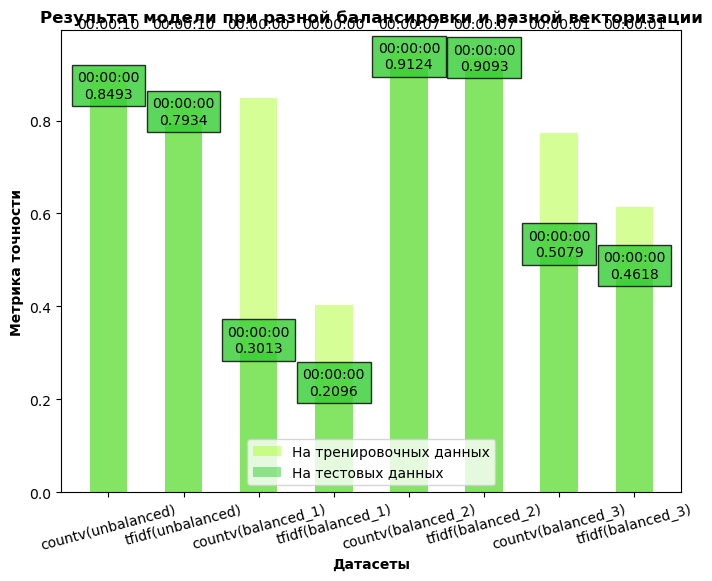

Wall time: 39.5 s


In [25]:
%%time
train_model(MLPClassifier, x_y_train_test, random_state=1, max_iter=1, hidden_layer_sizes=(100,))

In [53]:
params, model = {'hidden_layer_sizes': [(10,), (100,), (200,)],
          'max_iter': [1, 5],
          'random_state': [1]}, MLPClassifier

In [52]:
%%time
gridsearch_best(model, 'countv(balanced_3)', params)

accuracy_score train: 0.7883
accuracy_score test: 0.5248
Wall time: 15min 20s


{'alpha': 0.0001,
 'hidden_layer_sizes': (200,),
 'max_iter': 1,
 'random_state': 1}

In [54]:
%%time
gridsearch_best(model, 'countv(balanced_2)', params)

accuracy_score train: 0.9708
accuracy_score test: 0.9146
Wall time: 13min 42s


{'hidden_layer_sizes': (10,), 'max_iter': 5, 'random_state': 1}

Вывод: многослойная нейронная сеть по скорости обучения достаточно высокая и показывает результат бинарной классификации незначительно выше, чем метод опорных векторов. Но по определению 5 классов всё ещё уступает. Наблюдается как недообучение на некоторых датасетах. Подбор гиперпараметров занимает достаточно много времени и слабо улучшает метрики эффективности.

Итоговый вывод по моделям: наихудший способ баланса классов оказался метод понижения мажоритарных до уровня миноритарного; самые лучшие метрики показывает баланс до двух классов; определение 5 классов лучше всего показывает дисбалансный датасет. Далее следует протестировать определение оценки отзыва тремя способами.

In [27]:
final_result = {'model': [], 'train_time': [], 'test_time': [], 'accuracy': [], 'type': []}

In [29]:
for i in range(0, len(result['accuracy']) - 1, 2):
    j = i if result['accuracy'][i] >= result['accuracy'][i + 1] else (i + 1)
    final_result['model'].append(result['model'][j])
    final_result['train_time'].append(result['train_time'][j])
    final_result['test_time'].append(result['test_time'][j])
    final_result['accuracy'].append(result['accuracy'][j])
    final_result['type'].append(result['type'][j])

In [52]:
table = {'model': [], 'train_time': [], 'test_time': [], 'accuracy': []}
for i in range(len(final_result['model'])):
    if 'unbalanced' in final_result['type'][i]:
        table['model'].append(final_result['model'][i])
        table['train_time'].append(final_result['train_time'][i])
        table['test_time'].append(final_result['test_time'][i])
        table['accuracy'].append(final_result['accuracy'][i])
table = pd.DataFrame(table)
print("Обучение модели без баланса классов:")
table

Обучение модели без баланса классов:


,model,train_time,test_time,accuracy
0,LogisticRegression,00:00:06,00:00:00,0.8527
1,SVC,00:01:32,00:00:17,0.8544
2,KNeighborsClassifier,00:00:00,00:00:01,0.7803
3,DecisionTreeClassifier,00:00:05,00:00:00,0.7547
4,Perceptron,00:00:00,00:00:00,0.8268
5,MLPClassifier,00:00:10,00:00:00,0.8493


In [53]:
table = {'model': [], 'train_time': [], 'test_time': [], 'accuracy': []}
for i in range(len(final_result['model'])):
    if 'balanced_2' in final_result['type'][i]:
        table['model'].append(final_result['model'][i])
        table['train_time'].append(final_result['train_time'][i])
        table['test_time'].append(final_result['test_time'][i])
        table['accuracy'].append(final_result['accuracy'][i])
table = pd.DataFrame(table)
print("Обучение модели с двумя классами:")
table

Обучение модели с двумя классами:


,model,train_time,test_time,accuracy
0,LogisticRegression,00:00:00,00:00:00,0.9079
1,SVC,00:00:32,00:00:08,0.9106
2,KNeighborsClassifier,00:00:00,00:00:00,0.8378
3,DecisionTreeClassifier,00:00:04,00:00:00,0.8109
4,Perceptron,00:00:00,00:00:00,0.8904
5,MLPClassifier,00:00:07,00:00:00,0.9124


In [54]:
table = {'model': [], 'train_time': [], 'test_time': [], 'accuracy': []}
for i in range(len(final_result['model'])):
    if 'balanced_3' in final_result['type'][i]:
        table['model'].append(final_result['model'][i])
        table['train_time'].append(final_result['train_time'][i])
        table['test_time'].append(final_result['test_time'][i])
        table['accuracy'].append(final_result['accuracy'][i])
table = pd.DataFrame(table)
print("Обучение модели с пятью сбалансированными классами:")
table

Обучение модели с пятью сбалансированными классами:


,model,train_time,test_time,accuracy
0,LogisticRegression,00:00:01,00:00:00,0.5042
1,SVC,00:00:05,00:00:01,0.5297
2,KNeighborsClassifier,00:00:00,00:00:00,0.4279
3,DecisionTreeClassifier,00:00:01,00:00:00,0.4521
4,Perceptron,00:00:00,00:00:00,0.5079
5,MLPClassifier,00:00:01,00:00:00,0.5079


In [116]:
x_1, y_1 = x_y_train_test['tfidf(unbalanced)'][0], x_y_train_test['tfidf(unbalanced)'][2]
model_1 = SVC().fit(x_1, y_1)
x_2, y_2 = x_y_train_test['countv(balanced_2)'][0], x_y_train_test['countv(balanced_2)'][2]
model_2 = MLPClassifier(random_state=1, max_iter=1, hidden_layer_sizes=(100,)).fit(x_2, y_2)
x_3, y_3 = x_y_train_test['countv(balanced_3)'][0], x_y_train_test['countv(balanced_3)'][2]
model_3 = SVC(C=10, max_iter=200, tol=0.001).fit(x_3, y_3)

Проверим, как разные модели будут предсказывать оценку отзыва. В ходе эксперементов выяснилось, что третья модель с точностью предсказания в 57% слишком часто ошибается и её не стоит использовать. Модель, обученная на несбалансированных данных, определяет отзыв достаточно точно, и модель, обученная на данных с двумя классами, также определяет положительный или отрицательный отзыв. Но чтобы отзыв определялся правильно, он должен быть достаточно содержательным.

In [126]:
def predict(text, model_1, model_2) -> None:
    text = [text]
    # Векторизация текста
    stop_words = stopwords.words('russian')
    text_1 = tfidf(data, text)
    text_2 = countv(balanced_2, text)
    # Предсказание оценки
    model_1_prediction = model_1.predict(text_1)[0]
    model_2_prediction = "Положительный отзыв" if model_2.predict(text_2) == 1 else "Отзыв с претензиями"
    # Результат предсказания:
    print(model_1_prediction, model_2_prediction)

In [128]:
text = "Отличное обслуживание, хорошие условаия, приветливый персонал, всё хорошо объянил"
predict(text, model_1, model_2)

5 Положительный отзыв


In [136]:
text="""Мне необходимо до 18.09.2023 закрыть все счета в банке ВТБ. Примерно 20.08 я пришла в офис банка в Екатеринбурге. Закрыли все счета, кроме карты 2015 года с овердрафтом (кредитной линией). Ее служащая банка закрыть не смогла. Я написала отдельное заявление. Меня заверили, что после 4.09 кредитная линия закроется, и я могу снова прийти в офис и закрыть счет этой карты.
Я пришла 07.09 в офис в Санкт-Петербурге. Там тоже не знали, как закрыть эту кредитную линию. Я опять написала очередные заявление. При этом после закрытия этой кредитной линии я снова должна прийти в банк, чтобы закрыть счет этой карты. Я я могу это сделать только до 18.09. Почему все так сложно? Прошу решить мою проблему."""
predict(text, model_1, model_2)

1 Отзыв с претензиями


In [134]:
text="""Я уже несколько лет пользуюсь дебетовой картой Тинькофф, и могу с уверенностью сказать, что она просто отличная! Удобное мобильное приложение позволяет мне легко контролировать свои финансы, делать переводы и платежи, а также получать уведомления о каждой транзакции. Карта обладает широкой сетью бесплатных банкоматов, что экономит мои средства. Никогда не было проблем с работой карты, а поддержка клиентов всегда готова помочь. Безопасность также на высшем уровне благодаря технологии двухфакторной аутентификации. Я очень доволен своей дебетовой картой Тинькофф и рекомендую ее всем, кто ищет надежный и современный банк для своих финансов."""
predict(text, model_1, model_2)

5 Положительный отзыв


### Облако слов 

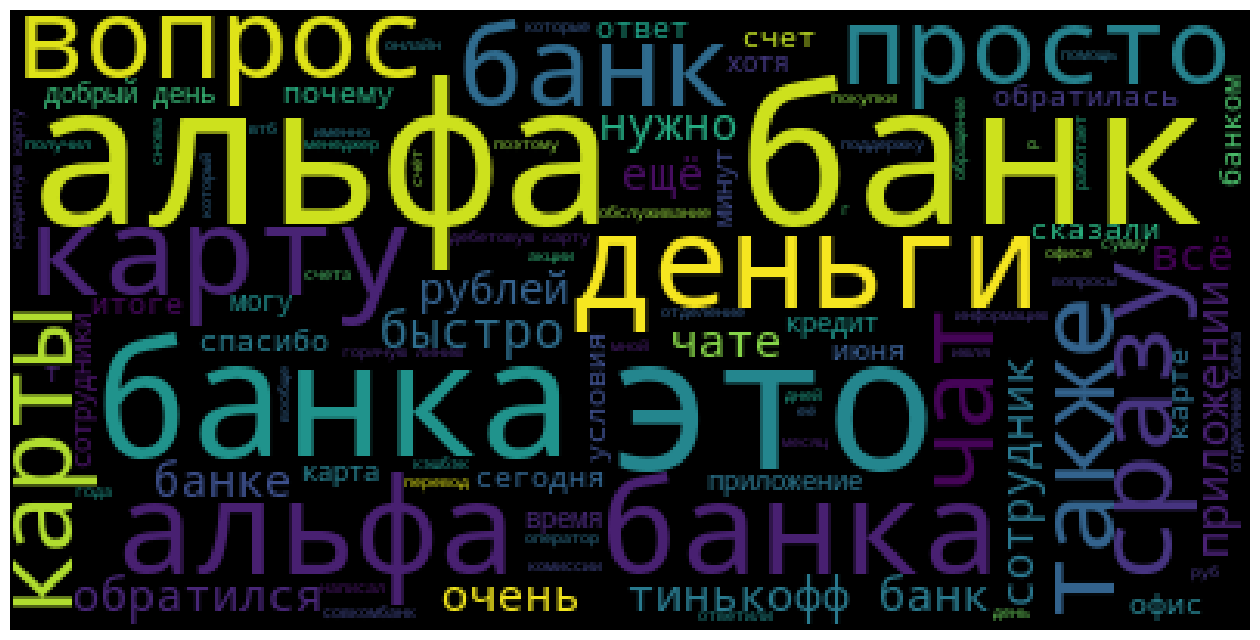

In [43]:
text = "".join(data["review"].str.cat(sep=""))
# генерируем облако слов
cloud = WordCloud(stopwords=stopwords.words('russian'),
                  contour_width=10, contour_color='#2e3043').generate(text)
# увеличим размер выводимой фигуры
plt.figure(figsize=(16, 9))
plt.imshow(cloud)
plt.axis('off')
plt.show()